In [8]:

import pandas as pd
file_patch = r'C:\Users\othma\Downloads\customer_booking.csv'
df = pd.read_csv(file_patch, encoding='latin1')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


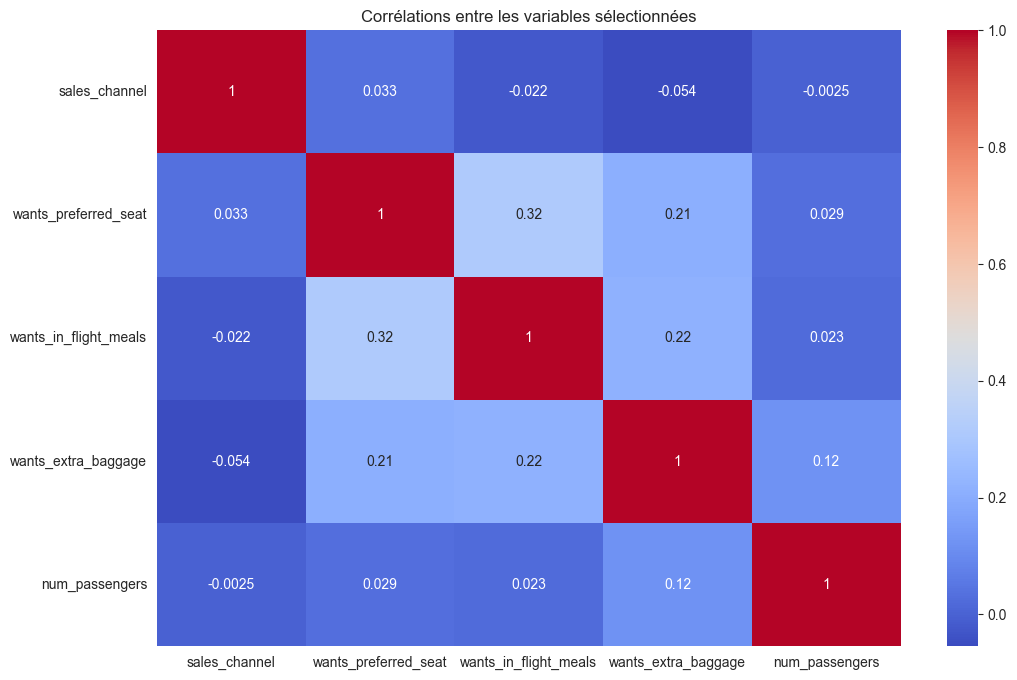

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
le=LabelEncoder()
df['sales_channel'] = le.fit_transform(df['sales_channel'])
# Exemple : Sélectionner les colonnes spécifiques
selected_columns = ['sales_channel', 'wants_preferred_seat', 'wants_in_flight_meals', 'wants_extra_baggage', 'num_passengers' ]

# Calculer les corrélations entre ces colonnes
correlation_matrix = df[selected_columns].corr()

# Visualiser avec une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Corrélations entre les variables sélectionnées")
plt.show()
# Encode categorical columns


In [10]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical columns
le = LabelEncoder()
df['flight_day'] = le.fit_transform(df['flight_day'])
df['sales_channel'] = le.fit_transform(df['sales_channel'])
df['trip_type'] = le.fit_transform(df['trip_type'])
df['route'] = le.fit_transform(df['route'])
df['booking_origin'] = le.fit_transform(df['booking_origin'])


In [11]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
# Feature Engineering
df['total_preferences'] = df['wants_extra_baggage'] + df['wants_preferred_seat'] + df['wants_in_flight_meals']
df['purchase_lead_category'] = pd.cut(
    df['purchase_lead'],
    bins=[0, 7, 30, 90, 365],
    labels=['last_minute', 'early', 'very_early', 'super_early']
)
df = pd.get_dummies(df, columns=['purchase_lead_category'], drop_first=True)

 #Create Interaction Features
#  Combining `num_passengers` and `trip_type`
df['passenger_trip_interaction'] = df['num_passengers'] * df['trip_type']

#  Combining `sales_channel` with `wants_extra_baggage`
df['channel_baggage_interaction'] = df['sales_channel'] * df['wants_extra_baggage']

# 2. Aggregate Features
#  Count bookings by sales_channel
booking_by_channel = df.groupby('sales_channel')['booking_complete'].transform('mean')
df['booking_rate_by_channel'] = booking_by_channel

# Average passengers per trip type
average_passengers_by_trip = df.groupby('trip_type')['num_passengers'].transform('mean')
df['avg_passengers_per_trip'] = average_passengers_by_trip
# Prepare features and target
x = df.drop('booking_complete', axis=1)
y = df['booking_complete']

# Handle Class Imbalance with SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter Tuning
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(x_train, y_train)

# Evaluate the model
y_pred = best_rf_model.predict(x_test)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Adjust Prediction Threshold
y_pred_prob = best_rf_model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
f1 = f1_score(y_test, y_pred_optimal)
print(f"Optimal F1 Score: {f1:.2f}")

F1 Score: 0.79
Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      8532
           1       0.83      0.75      0.79      4225

    accuracy                           0.87     12757
   macro avg       0.86      0.84      0.84     12757
weighted avg       0.86      0.87      0.86     12757

Optimal F1 Score: 0.79


In [12]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score , recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.87
Precision: 0.83
F1 Score: 0.79
